In [1]:
import pandas as pd
df = pd.read_csv('test.csv')
df.head()

,category,news
0,accident,['নওগাঁর মহাদেবপুর উপজেলার নওগাঁ-রাজশাহী মহাসড...
1,accident,['মংলা বন্দরের শিল্পাঞ্চল এলাকায় নির্মাণাধীন ...
2,accident,['মংলা বন্দরের শিল্পাঞ্চল এলাকায় নির্মাণাধীন ...
3,accident,['ঢাকা-ময়মনসিংহ রেললাইনের গাজীপুরের শ্রীপুর উ...
4,accident,['রাজধানীর পুরানা পল্টন থানা এলাকায় গতকাল বৃহ...


In [2]:
from io import StringIO
col = ['category', 'news']
df = df[col]
df = df[pd.notnull(df['news'])]
df.columns = ['category', 'news']
df['category_id'] = df['category'].factorize()[0]
category_id_df = df[['category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)
df.head()

,category,news,category_id
0,accident,['নওগাঁর মহাদেবপুর উপজেলার নওগাঁ-রাজশাহী মহাসড...,0
1,accident,['মংলা বন্দরের শিল্পাঞ্চল এলাকায় নির্মাণাধীন ...,0
2,accident,['মংলা বন্দরের শিল্পাঞ্চল এলাকায় নির্মাণাধীন ...,0
3,accident,['ঢাকা-ময়মনসিংহ রেললাইনের গাজীপুরের শ্রীপুর উ...,0
4,accident,['রাজধানীর পুরানা পল্টন থানা এলাকায় গতকাল বৃহ...,0


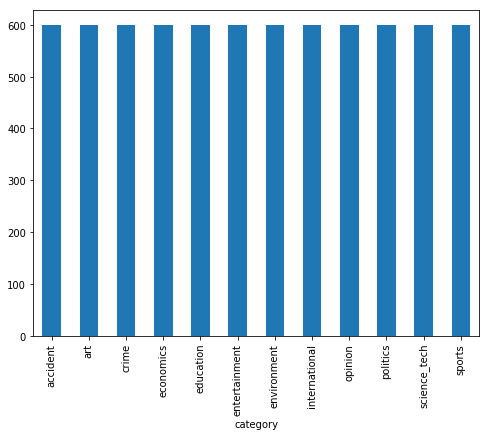

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('category').news.count().plot.bar(ylim=0)
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.news).toarray()
labels = df.category_id
features.shape
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))
    


# 'accident':
  . Most correlated unigrams:
. উপজ
. আহত
  . Most correlated bigrams:
. ঘটন ঘট
. ঘটন থল
# 'art':
  . Most correlated unigrams:
. বইট
. উপন
  . Most correlated bigrams:
. রথম রক
. রচ ছদ


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['news'], df['category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

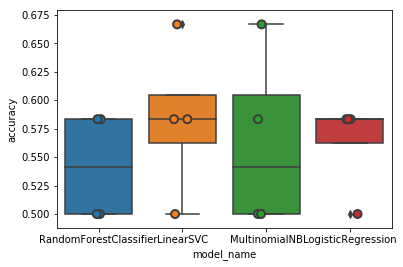

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 4
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [7]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.904546
LogisticRegression        0.875882
MultinomialNB             0.830800
RandomForestClassifier    0.692221
Name: accuracy, dtype: float64